In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from tqdm import tqdm

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[In a 1-pint jar with a tight-fitting lid comb...,32,2004-08-20 12:48:48,"[Cheese, Herb, Appetizer, Winter, Gourmet]",306,4,3.750,"Goat Cheese Marinated in Rosemary, Fennel, and...","[peeler, lemon, goat, log, oil, cheese, fennel...",106
1,"[Preheat oven to 400°F with rack in middle., T...",7,2008-10-16 04:00:00,"[Side, Roast, Thanksgiving, Vegetarian, Dinner...",168,6,4.375,Parmesan-Roasted Butternut Squash,"[parmigiano-reggiano, cream, sage, piece, squash]",142
2,[Cut an X in bottom of each tomato with a shar...,102,2004-09-21 20:28:40,"[Beef, Potato, Tomato, Bake, Fall, Winter, Gou...",1303,42,3.125,Croatian Moussaka,"[egg, potato, onion, parmigiano-reggiano, brea...",713
3,[Heat oil in heavy large pot over medium-heat....,13,2004-09-21 20:28:11,"[Soup/Stew, Pasta, Shellfish, Tomato, Sauté, C...",396,47,4.375,Ann Pachett's Spicy Seafood Chowder,"[scallop, onion, bell, parsley, shrimp, juice,...",2133
4,[Thinly slice cabbage and onion separately. In...,5,2004-08-20 04:00:00,"[Onion, Side, Quick & Easy, Vinegar, Fall, Cab...",100,2,3.750,Wilted Red Cabbage with Balsamic Vinegar,"[sugar, water, onion, vinegar, ground, pepper,...",35


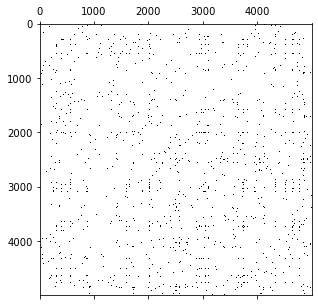

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
data_recipe.rating.value_counts()

4.375    2281
3.750    1437
5.000     675
3.125     396
2.500     147
1.250      42
1.875      22
Name: rating, dtype: int64

In [6]:
# Helper function for printing various graph properties.
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
        
        # Number of connected components.
        comp = list(nx.connected_components(G))
        print('The graph contains', len(comp), 'connected components')
        
        # Largest connected components properties.
        largest_comp = max(comp, key=len)
        percentage_lcc = len(largest_comp)/G.number_of_nodes() * 100
        print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')
        lcc_G = G.subgraph(largest_comp)
        print("The diameter of the largest connected component is", nx.diameter(lcc_G))
        print("The avg shortest path length of the largest connected component is", nx.average_shortest_path_length(lcc_G))
        
        # Smallest connected component properties.
        smallest_comp = min(comp, key=len)
        percentage_scc = len(smallest_comp)/G.number_of_nodes() * 100
        print('The smallest component has', len(smallest_comp), 'nodes', 'accounting for %.2f'% percentage_scc, '% of the nodes')
        scc_G = G.subgraph(smallest_comp)
        print("The diameter of the smallest connected component is", nx.diameter(scc_G))
        print("The avg shortest path length of the smallest connected component is", nx.average_shortest_path_length(scc_G))
        
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [7]:
graph = nx.from_numpy_array(adjacency_matrix[:1000,:1000])

In [10]:
# Add node attributes.
nx.set_node_attributes(graph, data_recipe['title'].to_dict(), 'title')
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')
nx.set_node_attributes(graph, data_recipe['ingredients'].to_dict(), 'ingredients')

In [8]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 9587
Average degree:  19.1740
Graph is not connected
Diameter and Avg shortest path length are not defined!
The graph contains 45 connected components
The largest component has 955 nodes accounting for 95.50 % of the nodes
The diameter of the largest connected component is 8
The avg shortest path length of the largest connected component is 3.1557311732358655
The smallest component has 1 nodes accounting for 0.10 % of the nodes
The diameter of the smallest connected component is 0
The avg shortest path length of the smallest connected component is 0
Sparsity: 0.0192
Global clustering coefficient aka Transitivity: 0.3244


Most of the nodes are in the giant/largest component, which is often the case in a graph.

In [15]:
# Which nodes/recipes contain the most common ingredients.
degrees = dict(graph.degree(graph.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# The top 5 most connected nodes/recipes.
for recipe, degree in sorted_degree[:5]:
    print('Node', recipe, 'which is', graph.node[recipe]['title'], 'has common ingredients with', degree, 'recipes:', graph.node[recipe]['ingredients'], '\n')

Node 673 which is Spicy Shrimp and Bell Pepper Stew with Cumin and Oregano  has common ingredients with 110 recipes: ['onion', 'bell', 'wine', 'water', 'parsley', 'shrimp', 'juice', 'ground', 'pepper', 'strip', 'tomato', 'paste', 'bay', 'oil', 'leaf'] 

Node 393 which is Marsala and Dried-Fig Crostata  has common ingredients with 103 recipes: ['sugar', 'water', 'cream', 'cinnamon', 'vanilla', 'ground', 'butter', 'fig', 'seed', 'brown', 'egg', 'ice'] 

Node 4 which is Wilted Red Cabbage with Balsamic Vinegar  has common ingredients with 102 recipes: ['sugar', 'water', 'onion', 'vinegar', 'ground', 'pepper', 'cabbage', 'oil'] 

Node 943 which is Apple Walnut Upside-Down Cake with Calvados Caramel Sauce  has common ingredients with 102 recipes: ['sugar', 'apple', 'water', 'cream', 'cinnamon', 'extract', 'vanilla', 'powder', 'butter', 'ginger', 'walnut', 'egg'] 

Node 732 which is Apricot-Sour Cream Scones  has common ingredients with 101 recipes: ['sugar', 'soda', 'cream', 'vanilla', 'but

We can see that that the recipes which contain the most common ingredients are:
- Spicy Shrimp and Bell Pepper Stew with Cumin and Oregano
- Marsala and Dried-Fig Crostata
- Wilted Red Cabbage with Balsamic Vinegar
- Apple Walnut Upside-Down Cake with Calvados Caramel Sauce
- Apricot-Sour Cream Scones

By looking at their ingredients one can conclude that among the most common ingredients we can name:
- egg
- water
- sugar
- butter
- cream

We can see that the most connected recipe nodes are from different categories. 3 are desserts and the other 2 are proper main dishes. This is reasonable, however, as the ingredients we mentioned above tend to be used in most types of recipes and across different categories. Hence, because these recipe nodes each has a subset of them, they ended up being hubs.


In [18]:
# Helper function for plotting the degree distribution of a Graph.
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots(figsize=(28,10))
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

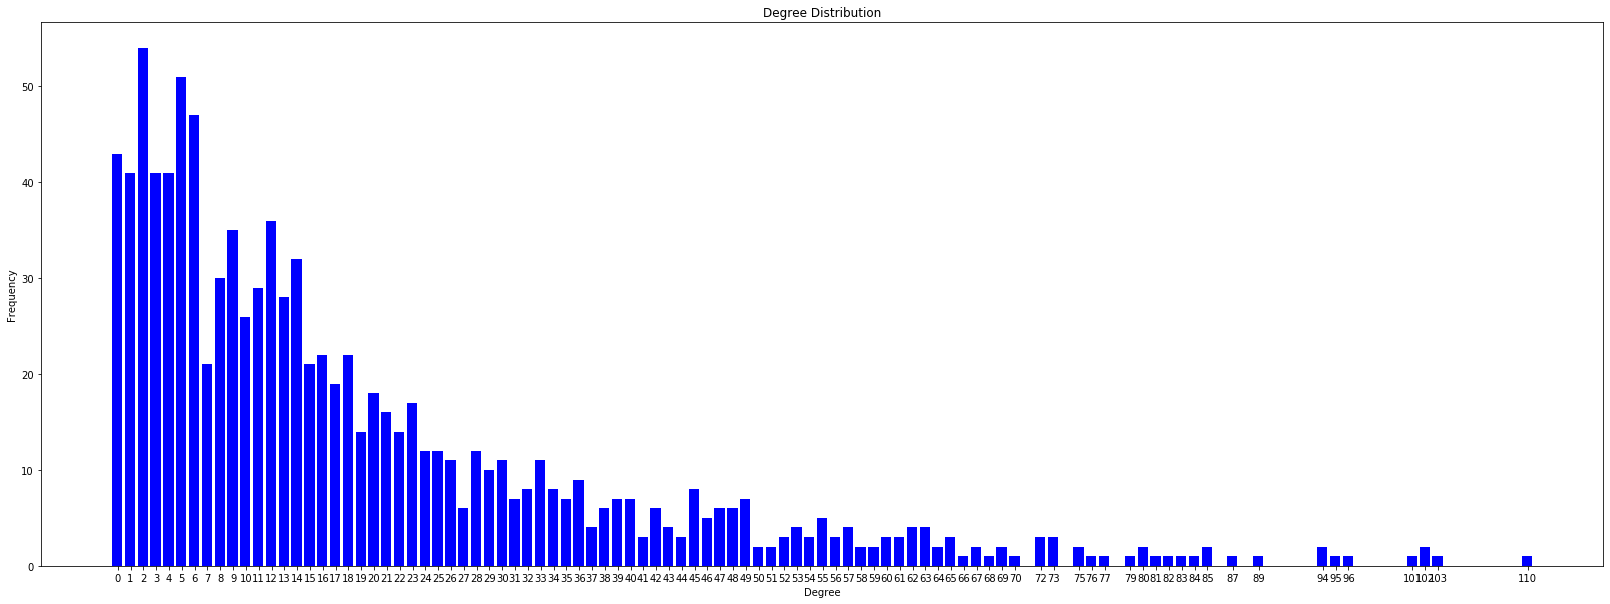

In [19]:
plot_degree_distribution(graph)

The degree distribution of the network seems to follow a power law. This means that most recipes are connected to fe othe recipes (have common ingredients), but there are a small number of "hub", i.e. recipes which are connected to many other recipes because contain a large number of the most basic, common ingredients across different types of cuisines.

In [20]:
nx.attribute_assortativity_coefficient(graph, 'calories')

-0.0022599951625912203

In [21]:
nx.attribute_assortativity_coefficient(graph, 'protein')

0.017998523407026023

In [22]:
nx.attribute_assortativity_coefficient(graph, 'fat')

0.01047536412191416

In [23]:
nx.attribute_assortativity_coefficient(graph, 'sodium')

-0.0007091516775854209

In [24]:
nx.attribute_assortativity_coefficient(graph, 'rating')

0.008644577338864

In [75]:
nx.attribute_assortativity_coefficient(graph, 'title')

-0.0020510465693881113